# Lab : Using Convolutional Neural Networks (CNN) to identify Images

In this lab, we are going to setup a CNN to classify CIFAR dataset

References
- https://www.tensorflow.org/tutorials/images/cnn
- https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb

## About CIFAR Data

* CIFFAR-10 dataset consists of
    - 60,000 color images
    - 32x32 pixels, color
    - 10 classes (6,000 per class)
* 50,000 training images; 10,000 test images
* 5 training batches, 1 test batch
    - 10,000 images per batch  
    - Each batch has 1000 random images from each class
* **Size ~160 MB**


<img src="https://elephantscale-public.s3.amazonaws.com/media/CIFAR-10-dataset.png" />

In [ ]:
## Determine if we are running on google colab

try:
    import google.colab
    RUNNING_IN_COLAB = True
except:
    RUNNING_IN_COLAB = False

print ("Running in Google COLAB : ", RUNNING_IN_COLAB)

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
print ("tf version: ", tf.__version__)
print ("keras version: ", keras.__version__)

tf version:  2.1.0
keras version:  2.2.4-tf


## TF-GPU Debug
The following block tests if TF is running on GPU.

In [3]:
## This block is to tweak TF running on GPU
## You may comment this out, if you are not using GPU


import os, sys

## disable info logs from TF
#   Level | Level for Humans | Level Description                  
#  -------|------------------|------------------------------------ 
#   0     | DEBUG            | [Default] Print all messages       
#   1     | INFO             | Filter out INFO messages           
#   2     | WARNING          | Filter out INFO & WARNING messages 
#   3     | ERROR            | Filter out all messages 

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
tf.get_logger().setLevel('WARN')


## ---- start Memory setting ----
## Ask TF not to allocate all GPU memory at once.. allocate as needed
## Without this the execution will fail with "failed to initialize algorithm" error

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
## ---- end Memory setting ----


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## Step 1: Download Data

In [4]:
from tensorflow.keras import datasets

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()


print("train_images shape : ", train_images.shape)
print("train_labels shape : ", train_labels.shape)
print("test_images shape : ", test_images.shape)
print("test_labels shape : ", test_labels.shape)

train_images shape :  (50000, 32, 32, 3)
train_labels shape :  (50000, 1)
test_images shape :  (10000, 32, 32, 3)
test_labels shape :  (10000, 1)


## Step 2: Data Exploration

### Print out some random image

Displaying train index =  32967
train label [32967] = 0 = airplane
------------ raw data for train_image[32967] -------
--------------------


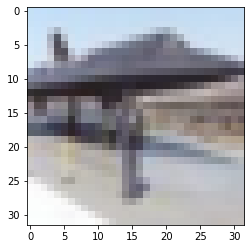

In [5]:
## Run this cell a few times to randomly display some digit data

import matplotlib.pyplot as plt
import random

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

index = random.randint(0, len(train_images))
# index = 10
print ("Displaying train index = ", index)

print("train label [{}] = {} = {}".format(index, train_labels[index][0], class_names[train_labels[index][0]]))
print ("------------ raw data for train_image[{}] -------".format(index))
# print(train_images[index])
print ("--------------------")

plt.imshow(train_images[index])

### Print out some samples

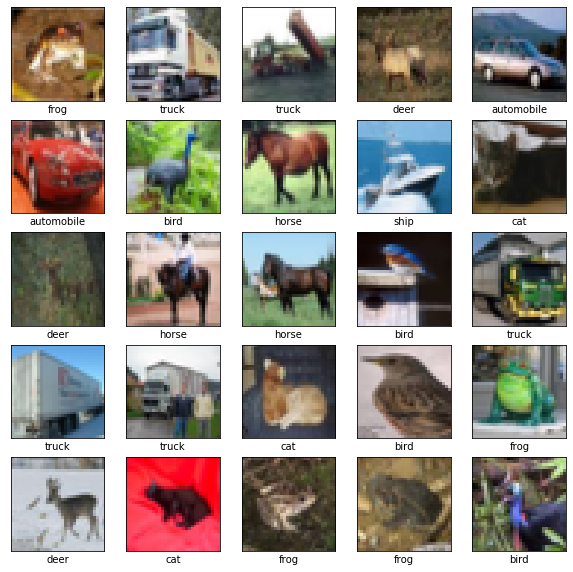

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Step 3 : Shape Data

### 3.1 - Normalize Data

Each pixel is a value from 0 to 255  
We are going to normalize them in the range of 0 to 1

In [7]:
## Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

## Step 4 : Create Model

### 4.1 - Create a CNN

The code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure our CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument input_shape to our first layer..

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________
None


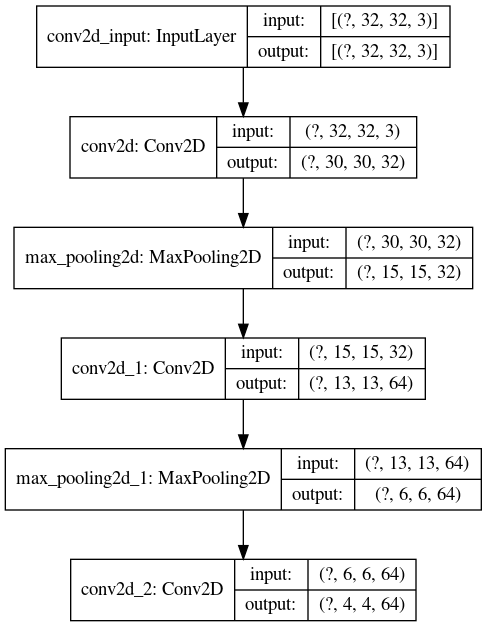

In [8]:

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))

print (model.summary())
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically, as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### 4.2 - Add Dense layers on top
To complete our model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs and a softmax activation.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

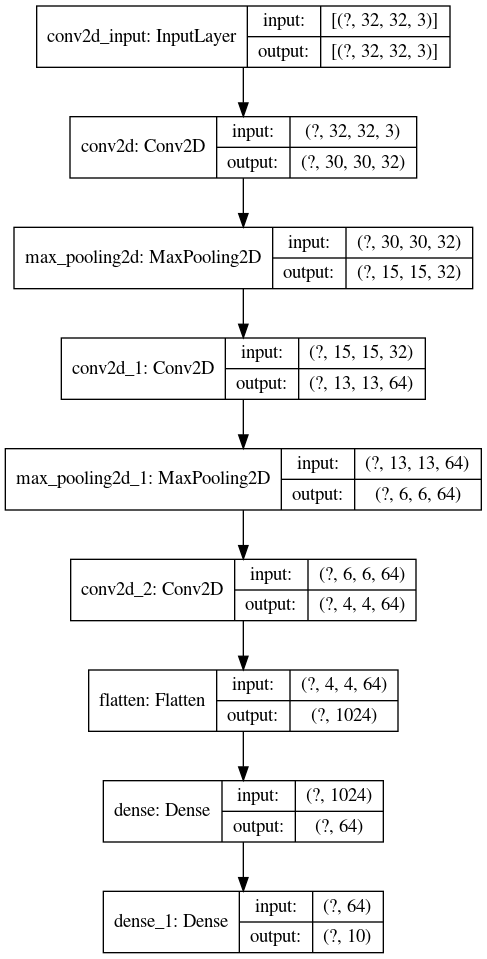

In [9]:
## TODO : complete the CNN
##   - First Dense layer = 64 neurons
##   - Last layer = 10 neurons and actuvation=tf.nn.softmax

## Questions
##   - why does last layer has 10 neurons?
##   - why is the last activation function SoftMax instead of ReLU?

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

print(model.summary())
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

### 4.3 - Compile

In [10]:
# loss='sparse_categorical_crossentropy'
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),

model.compile(optimizer=tf.keras.optimizers.Adam(),  # 'adam'
              loss=loss,
              metrics=['accuracy'])

## Step 5 - Setup Tensorboard

In [11]:
## This is fairly boiler plate code

import datetime
import os
import shutil

app_name = 'cnn-cifar'

tb_top_level_dir= '/tmp/tensorboard-logs'

# tensorboard_logs_dir= os.path.join (tb_top_level_dir, app_name, 
#                                     datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S"))

tensorboard_logs_dir= os.path.join (tb_top_level_dir, app_name)

print ("Saving TB logs to : " , tensorboard_logs_dir)

#clear out old logs
shutil.rmtree ( tensorboard_logs_dir, ignore_errors=True )

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_logs_dir, 
                                                      write_graph=True, write_images=True, histogram_freq=5)

## This will embed Tensorboard right here in jupyter!
%load_ext tensorboard
%tensorboard --logdir $tensorboard_logs_dir



Saving TB logs to :  /tmp/tensorboard-logs/cnn-cifar


Reusing TensorBoard on port 6009 (pid 30594), started 0:05:42 ago. (Use '!kill 30594' to kill it.)

## Step 6 : Train

In [12]:
%%time

epochs = 10

print ("training starting ...")
history = model.fit(train_images, train_labels, 
                    epochs=epochs, validation_split = 0.2, verbose=1,
                    callbacks=[tensorboard_callback])
print ("training done.")

training starting ...
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 5s 124us/sample - loss: 2.1355 - accuracy: 0.3153 - val_loss: 2.0470 - val_accuracy: 0.4079
Epoch 2/10
40000/40000 [==============================] - 3s 87us/sample - loss: 2.0341 - accuracy: 0.4211 - val_loss: 2.0223 - val_accuracy: 0.4344
Epoch 3/10
40000/40000 [==============================] - 3s 84us/sample - loss: 1.9909 - accuracy: 0.4661 - val_loss: 1.9836 - val_accuracy: 0.4717
Epoch 4/10
40000/40000 [==============================] - 3s 84us/sample - loss: 1.9602 - accuracy: 0.4978 - val_loss: 1.9588 - val_accuracy: 0.4979
Epoch 5/10
40000/40000 [==============================] - 3s 85us/sample - loss: 1.9411 - accuracy: 0.5178 - val_loss: 1.9340 - val_accuracy: 0.5252
Epoch 6/10
40000/40000 [==============================] - 3s 85us/sample - loss: 1.9213 - accuracy: 0.5368 - val_loss: 1.9382 - val_accuracy: 0.5205
Epoch 7/10
40000/40000 [=========

## Step 7 : See Training History

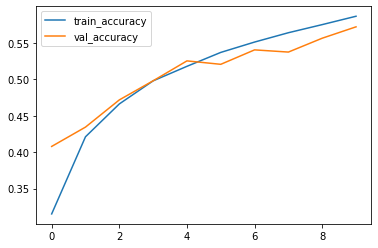

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

## Step 8 - Predict

**==> Compare prediction time vs training time.  Prediction is very quick!**

In [14]:
%%time 

print ("predicting on {:,} images".format(len(test_images)))
predictions = model.predict(test_images)


predicting on 10,000 images
CPU times: user 881 ms, sys: 186 ms, total: 1.07 s
Wall time: 552 ms


random index =  2232
test_label[2232] = [0].  So the number is [0]
prediction of test_image[2232] = [ 0.000  0.996  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.004]
max softmax output =  0.9958669
index of max softmax output = 1.  So the prediction is same (1)


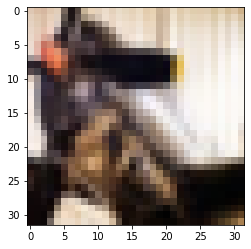

In [15]:
## Print a sample prediction

%matplotlib inline
import matplotlib.pyplot as plt
import random
import numpy as np
from pprint import pprint

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

index = random.randint(0, len(test_images))

print ("random index = ", index)
print ("test_label[{}] = {}.  So the number is {}".format(index, test_labels[index], test_labels[index]))
print ("prediction of test_image[{}] = {}".format(index, predictions[index]))
print ('max softmax output = ', np.amax(predictions[index]))
print ('index of max softmax output = {}.  So the prediction is same ({})'.format(np.argmax(predictions[index]), np.argmax(predictions[index])))

plt.imshow(test_images[index])

## Step 9 : Evaluate the Model 

### 9.1 - Metrics

In [16]:
metric_names = model.metrics_names
print ("model metrics : " , metric_names)

metrics = model.evaluate(test_images, test_labels, verbose=0)

for idx, metric in enumerate(metric_names):
    print ("Metric : {} = {:,.3f}".format (metric_names[idx], metrics[idx]))

model metrics :  ['loss', 'accuracy']
Metric : loss = 1.892
Metric : accuracy = 0.567


### 9.2 - Confusion Matrix

In [17]:
## our predictions is an array of arrays
print('predictions shape : ', predictions.shape)
print ('prediction 0 : ' , predictions[0])
print ('prediction 1 : ' , predictions[1])

predictions shape :  (10000, 10)
prediction 0 :  [ 0.000  0.000  0.001  0.982  0.000  0.017  0.000  0.000  0.001  0.000]
prediction 1 :  [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000]


In [18]:
## We need to find the final output (max of softmax probabilities for each prediction)
predictions2 = [ np.argmax(p) for p in predictions]
print ('prediction2 0 : ' , predictions2[0])
print ('prediction2 1 : ' , predictions2[1])

prediction2 0 :  3
prediction2 1 :  8


In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, predictions2, labels = [0,1,2,3,4,5,6,7,8,9])
cm

array([[  0,  72, 221,  30, 101,  20,  20,  23, 401, 112],
       [  0, 782,  11,  10,   9,   5,  17,   7,  62,  97],
       [  0,  15, 429,  87, 184,  84, 115,  23,  43,  20],
       [  0,  16,  71, 446, 112, 165, 110,  33,  19,  28],
       [  0,  13,  68,  70, 597,  39, 115,  77,  15,   6],
       [  0,  12,  70, 199,  82, 496,  61,  46,  15,  19],
       [  0,  11,  41,  57,  61,  17, 784,  10,   9,  10],
       [  0,  12,  37,  67, 100,  84,  20, 627,   6,  47],
       [  0,  44,  29,  22,  20,  11,  15,   7, 801,  51],
       [  0, 136,  13,  32,   6,  10,  22,  20,  53, 708]])

index <> category mapping:
0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


[]

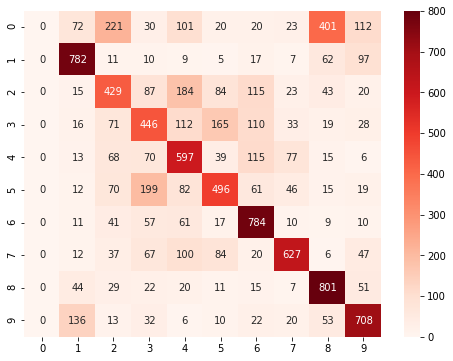

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

print ("index <> category mapping:")
for index, value in enumerate(class_names): 
    print(index, value) 

plt.figure(figsize = (8,6))

# colormaps : cmap="YlGnBu" , cmap="Greens", cmap="Blues",  cmap="Reds"
sns.heatmap(cm, annot=True, cmap="Reds", fmt='d').plot()

### 9.3 - Metrics Calculated from Confusion Matrix

In [21]:
from sklearn.metrics import classification_report
from pprint import pprint

pprint(classification_report(test_labels, predictions2, output_dict=True))

{'0': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 1000},
 '1': {'f1-score': 0.7401798390913394,
       'precision': 0.7026055705300989,
       'recall': 0.782,
       'support': 1000},
 '2': {'f1-score': 0.4311557788944724,
       'precision': 0.43333333333333335,
       'recall': 0.429,
       'support': 1000},
 '3': {'f1-score': 0.4415841584158416,
       'precision': 0.4372549019607843,
       'recall': 0.446,
       'support': 1000},
 '4': {'f1-score': 0.5255281690140845,
       'precision': 0.4693396226415094,
       'recall': 0.597,
       'support': 1000},
 '5': {'f1-score': 0.5137234593474884,
       'precision': 0.5327604726100966,
       'recall': 0.496,
       'support': 1000},
 '6': {'f1-score': 0.6880210618692408,
       'precision': 0.6129788897576232,
       'recall': 0.784,
       'support': 1000},
 '7': {'f1-score': 0.6695141484249867,
       'precision': 0.718213058419244,
       'recall': 0.627,
       'support': 1000},
 '8': {'f1-score': 0.66089108

/home/sujee/anaconda3/envs/tf2-gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Step 10 : Improve the Model

Try the following exercises

**1 - Increase epochs**  
- In Step-6, increase epochs to 10
- Rerun the notebook
- did the accuracy improve?
- how much the training time go up?